# Self-Driving Car Engineer Nanodegree
## Project: **Finding Lane Lines on the Road** 

## Import packages

In [62]:
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Function definitions

In [72]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black."""
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """`img` should be the output of a Canny transform.
    Returns an image with hough lines drawn."""
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """`img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    `initial_img` should be the image before any processing.
    The result image is computed as follows: initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!"""
    return cv2.addWeighted(initial_img, α, img, β, λ)

def plot_all_images(images,gray=False):
    """Takes a list of images as input and plots them"""
    for image in images:
        plt.figure(figsize = (10,10))
        if(gray):
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)

def plot_image(image,title='',gray=False):
    """Takes an image as input and plots it"""
    plt.figure(figsize = (10,10))
    plt.title(title)
    if(gray):
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)

class DrawLines(object):
    """To keep state of previous frames, which helps to smooth out the detection of lane lines,
    this class is callable and keeps a running average of the past `buffer_size` frames."""
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.lft_avg_x1 = deque(5*[0.], self.buffer_size())
        self.lft_avg_x2 = deque(5*[0.], self.buffer_size())
        self.lft_avg_y1 = deque(5*[0.], self.buffer_size())
        self.lft_avg_y2 = deque(5*[0.], self.buffer_size())
        self.rht_avg_x1 = deque(5*[0.], self.buffer_size())
        self.rht_avg_x2 = deque(5*[0.], self.buffer_size())
        self.rht_avg_y1 = deque(5*[0.], self.buffer_size())
        self.rht_avg_y2 = deque(5*[0.], self.buffer_size())
    
    def buffer_size(self):
        return 20
    
    def __call__(self, img, lines, color=[255, 0, 0], thickness=3):
        lft_x1=[]
        lft_x2=[]
        lft_y1=[]
        lft_y2=[]
        rht_x1=[]
        rht_x2=[]
        rht_y1=[]
        rht_y2=[]

        for line in lines:
            for x1,y1,x2,y2 in line:
                angle = np.arctan2((y1-y2),(x1-x2))*180/np.pi
                if(np.absolute(angle) < 170 and np.absolute(angle) > 130):
                    slope = ((y2-y1)/(x2-x1))
                    if(slope < 0):
                        lft_x1.append(x1)
                        lft_x2.append(x2)
                        lft_y1.append(y1)
                        lft_y2.append(y2)
                    elif(slope > 0):
                        rht_x1.append(x1)
                        rht_x2.append(x2)
                        rht_y1.append(y1)
                        rht_y2.append(y2)

        self.lft_avg_x1.append(sum(lft_x1)/len(lft_x1))
        self.lft_avg_x2.append(sum(lft_x2)/len(lft_x2))
        self.lft_avg_y1.append(sum(lft_y1)/len(lft_y1))
        self.lft_avg_y2.append(sum(lft_y2)/len(lft_y2))
        self.rht_avg_x1.append(sum(rht_x1)/len(rht_x1))
        self.rht_avg_x2.append(sum(rht_x2)/len(rht_x2))
        self.rht_avg_y1.append(sum(rht_y1)/len(rht_y1))
        self.rht_avg_y2.append(sum(rht_y2)/len(rht_y2))
        
        #first entry to __call__ will require filling the buffer to
        #calculate a sensible average
        while(any(x==0. for x in self.lft_avg_x1)):
            self.lft_avg_x1.append(sum(lft_x1)/len(lft_x1))
            self.lft_avg_x2.append(sum(lft_x2)/len(lft_x2))
            self.lft_avg_y1.append(sum(lft_y1)/len(lft_y1))
            self.lft_avg_y2.append(sum(lft_y2)/len(lft_y2))
            self.rht_avg_x1.append(sum(rht_x1)/len(rht_x1))
            self.rht_avg_x2.append(sum(rht_x2)/len(rht_x2))
            self.rht_avg_y1.append(sum(rht_y1)/len(rht_y1))
            self.rht_avg_y2.append(sum(rht_y2)/len(rht_y2))
 
        lft_params = np.polyfit([sum(self.lft_avg_x1)/len(self.lft_avg_x1),
                                 sum(self.lft_avg_x2)/len(self.lft_avg_x2)],
                                [sum(self.lft_avg_y1)/len(self.lft_avg_y1),
                                 sum(self.lft_avg_y2)/len(self.lft_avg_y2)], 1)
        rht_params = np.polyfit([sum(self.rht_avg_x1)/len(self.rht_avg_x1),
                                 sum(self.rht_avg_x2)/len(self.rht_avg_x2)],
                                [sum(self.rht_avg_y1)/len(self.rht_avg_y1),
                                 sum(self.rht_avg_y2)/len(self.rht_avg_y2)], 1)

        lft_poly = np.poly1d(lft_params)
        rht_poly = np.poly1d(rht_params)

        imshape = img.shape
        cv2.line(img, (0, int(lft_poly(0))), (450, int(lft_poly(450))), color, thickness)
        cv2.line(img, (520, int(rht_poly(520))), (imshape[1], int(rht_poly(imshape[1]))), color, thickness)

## Processing pipeline

In [73]:
def process_image(image,uniq=0,save_image=False):
    canny_low_threshold = 40
    imshape = test_images[0].shape
    vertices = np.array([[(0,imshape[0]), (450, 325), (520, 325), (imshape[1],imshape[0])]], dtype=np.int32)
    
    imgray = grayscale(image)
    imgauss = gaussian_blur(imgray,11)
    imcanny = canny(imgauss,canny_low_threshold,canny_low_threshold*3)
    immask = region_of_interest(imcanny,vertices)
    imhough = hough_lines(immask, 1, np.pi/180, 15, 5, 5)
    imweight = weighted_img(imhough, image)
    
    result = imweight

    if(save_image):
        cv2.imwrite("test_images_output/" + str(uniq) + "_original.jpg", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        cv2.imwrite("test_images_output/" + str(uniq) + "_grayscale.jpg", imgray)
        cv2.imwrite("test_images_output/" + str(uniq) + "_gaussian.jpg", imgauss)
        cv2.imwrite("test_images_output/" + str(uniq) + "_cannyedge.jpg", imcanny)
        cv2.imwrite("test_images_output/" + str(uniq) + "_masked.jpg", immask)
        cv2.imwrite("test_images_output/" + str(uniq) + "_houghlines.jpg", cv2.cvtColor(imhough, cv2.COLOR_RGB2BGR))
        cv2.imwrite("test_images_output/" + str(uniq) + "_overlayed.jpg", cv2.cvtColor(imweight, cv2.COLOR_RGB2BGR))
    
    return result

## Processing test images

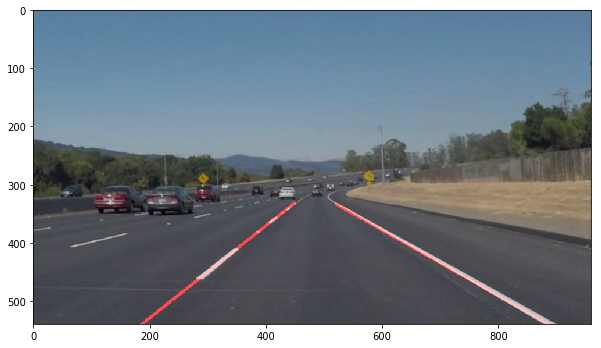

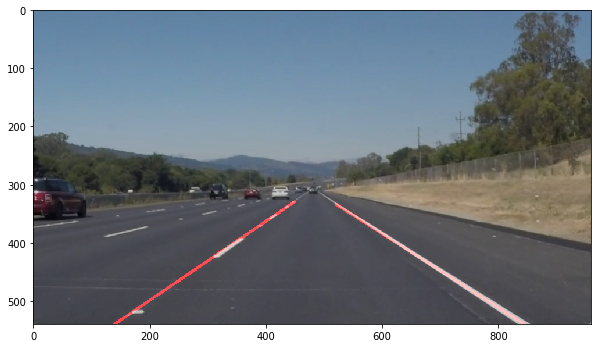

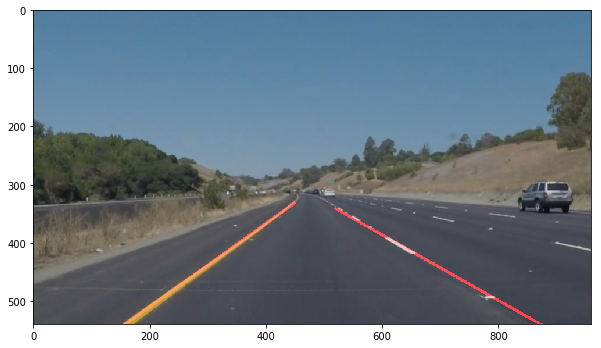

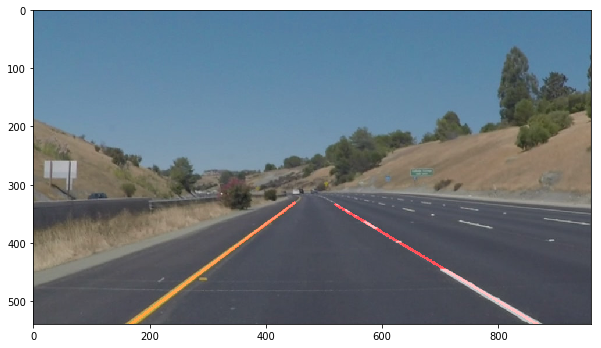

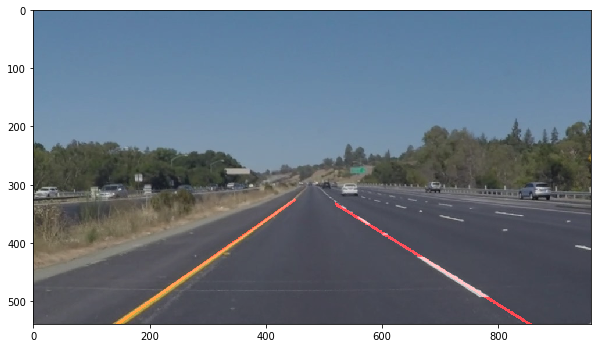

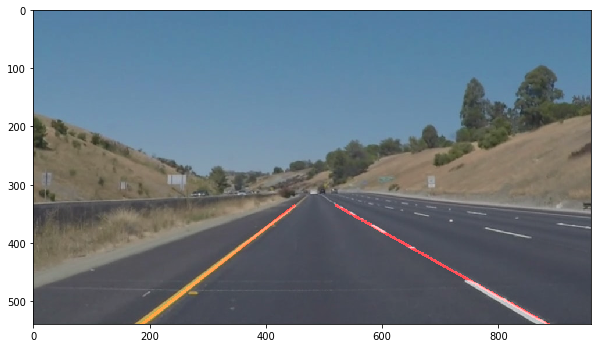

In [74]:
draw_lines = DrawLines()

#get input image files
test_image_list = os.listdir("test_images/")

#create empty lists for populating with images
test_images = []
test_images_processed = []

#read in test images
for image in test_image_list:
    test_images.append(mpimg.imread('test_images/'+image))

#process images
i=0
for image in test_images:
    test_images_processed.append(process_image(image,i,True))
    i+=1
    draw_lines.reset()

plot_all_images(test_images_processed)

## Processing test video 1

In [75]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

#close file to prevent bad handle error when attempting to re-process
clip1.reader.close()
clip1.audio.reader.close_proc()
white_clip.reader.close()
white_clip.audio.reader.close_proc()

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████▌| 221/222 [00:07<00:00, 30.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 8.17 s


## Processing test video 2

In [76]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

#close file to prevent bad handle error when attempting to re-process
clip2.reader.close()
clip2.audio.reader.close_proc()
yellow_clip.reader.close()
yellow_clip.audio.reader.close_proc()

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████▊| 681/682 [00:21<00:00, 31.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 22.8 s


## Processing test video 3
### This test video is much more challenging - the algorithm has not yet been tuned for this video

In [77]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

#close file to prevent bad handle error when attempting to re-process
clip3.reader.close()
clip3.audio.reader.close_proc()
challenge_clip.reader.close()
challenge_clip.audio.reader.close_proc()

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▏| 125/126 [00:07<00:00, 13.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 10.1 s


---